In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers

URL_DIR = "https://www.cs.toronto.edu/~kriz/"
FILE_NAME_CIFAR_100 = "cifar-100-python.tar.gz"

def load_and_unzip_cifar(url: str, file_name: str):
    from pathlib import Path
    import requests, tarfile

    full_url_to_load = url + file_name
    if Path(file_name).exists() and Path(file_name).is_file():
        print(f"Файл {file_name} вже є. Немає потреби його завантажувати!")
    else:
        print(f"Завантажуємо файл {file_name}")
        response = requests.get(full_url_to_load)
        with open(file_name, 'wb') as file:
            file.write(response.content)

    work_dir = Path(str((Path() / Path(file_name).stem)).split(".")[0])
    if work_dir.exists() and work_dir.is_dir():
        print(f"Директорія {work_dir} вже існує, перезаписуємо файли")
        with tarfile.open(file_name, 'r:gz') as tar:
            tar.extractall()
    else:
        print(f"Розпакуємо файл {file_name}")
        with tarfile.open(file_name, 'r:gz') as tar:
            tar.extractall()

load_and_unzip_cifar(URL_DIR, FILE_NAME_CIFAR_100)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = './cifar-100-python/meta'
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

data_pre_path = './cifar-100-python/'
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'

data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)

data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'coarse_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'coarse_labels'])

data_train = data_train.reshape(len(data_train), 3, 32, 32).transpose(0, 2, 3, 1)
data_test = data_test.reshape(len(data_test), 3, 32, 32).transpose(0, 2, 3, 1)

data_train = data_train.astype("float32")
data_test = data_test.astype("float32")
data_train = (data_train - 127.5) / 127.5
data_test = (data_test - 127.5) / 127.5


Завантажуємо файл cifar-100-python.tar.gz
Розпакуємо файл cifar-100-python.tar.gz


# Архітектура Генеративної та Дискримінативної Мереж

In [2]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


# Процес навчання

In [3]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 50
BATCH_SIZE = 256
BUFFER_SIZE = 60000
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print ('Epoch {} завершено'.format(epoch + 1))

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# Запуск навчання

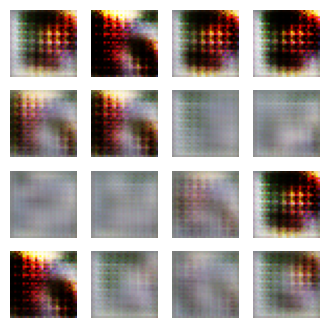

Epoch 4 завершено


KeyboardInterrupt: 

In [7]:

from IPython.display import clear_output

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print('Epoch {} завершено'.format(epoch + 1))


train_dataset = tf.data.Dataset.from_tensor_slices(data_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)

